# Which one is a better plan?

You work as an analyst for the telecom operator Megaline. The company offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

You are going to carry out a preliminary analysis of the plans based on a relatively small client selection. You'll have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. Your job is to analyze the clients' behavior and determine which prepaid plan brings in more revenue.

Source: This data came from a sample of 500 Megaline users in 2018, in the form of five datasets that provide information on users, phone plans, and the users' phone/message/internet consumption.

My primary goal is to determine which prepaid plan generates more revenue for the company. Revenue in this case is measured simply by the amount of money gained from the sales of these two plans.

My plan:
1. For each table:
    - Explore the data. Convert datatypes. Fix duplicates. Fix missing values.
2. Calculate the monthly revenue generated per user
    - For calls, texts, and data, calculate extra usage fee then add flat fee.
    - I can make a table containing this data, and their plan.
3. Get summary statistics for the customers' behavior, grouping by plan.
    - Boxplot? Histograms? .describe(). Also calculate variance
4. Test alternative hypotheses:
    - Average revenue for each plan differs.
    - Average revenue for NY-NJ area differs from in other regions.
    - Use a T-test for independent samples to test both hypotheses.
    
I will practice my exploratory data analysis skills, learn to think critically about statistical methods, and learn to write about my statistical results.

## Initialization

In [1]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

## Load data

In [2]:
# Load the data files into different DataFrames
calls = pd.read_csv('megaline_calls.csv')
internet = pd.read_csv('megaline_internet.csv')
messages = pd.read_csv('megaline_messages.csv')
plans = pd.read_csv('megaline_plans.csv')
users = pd.read_csv('megaline_users.csv')

## Prepare the data

### Plans

In [3]:
display(messages.head())
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d')
messages.info()

# Data types and values make sense.

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [4]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [5]:
# Print a sample of data for plans
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


#### Fix and Enrich Plans DataFrame

In [6]:
# Change plan name to category dtype
plans.plan_name = plans.plan_name.astype('category')
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   messages_included      2 non-null      int64   
 1   mb_per_month_included  2 non-null      int64   
 2   minutes_included       2 non-null      int64   
 3   usd_monthly_pay        2 non-null      int64   
 4   usd_per_gb             2 non-null      int64   
 5   usd_per_message        2 non-null      float64 
 6   usd_per_minute         2 non-null      float64 
 7   plan_name              2 non-null      category
dtypes: category(1), float64(2), int64(5)
memory usage: 366.0 bytes


I see no pressing issues with the data. The values all match up with the descriptions of the two plans. Visually, it is evident that there are no duplicates or missing values. I will, however, change the plan_name values to categorical data types. If I end up merging tables, this might save on processing power later. 

###############################################################################################################################

### Users

In [7]:
# Print the general/summary information about the users' DataFrame
users.info()
users.plan.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


count      500
unique       2
top       surf
freq       339
Name: plan, dtype: object

Looks like every user is attached to the correct two plans.

In [8]:
users.duplicated(subset='user_id').sum() # Check for duplicate user IDs

0

In [9]:
# Print a sample of data for users
display(users.head())

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


In [10]:
sorted(users.city.unique())
# 'New York-Newark-Jersey City, NY-NJ-PA MSA' is the area that we will look at later.

['Albany-Schenectady-Troy, NY MSA',
 'Albuquerque, NM MSA',
 'Atlanta-Sandy Springs-Roswell, GA MSA',
 'Austin-Round Rock-Georgetown, TX MSA',
 'Bakersfield, CA MSA',
 'Baltimore-Columbia-Towson, MD MSA',
 'Baton Rouge, LA MSA',
 'Birmingham-Hoover, AL MSA',
 'Boston-Cambridge-Newton, MA-NH MSA',
 'Bridgeport-Stamford-Norwalk, CT MSA',
 'Buffalo-Cheektowaga, NY MSA',
 'Cape Coral-Fort Myers, FL MSA',
 'Charleston-North Charleston, SC MSA',
 'Charlotte-Concord-Gastonia, NC-SC MSA',
 'Chicago-Naperville-Elgin, IL-IN-WI MSA',
 'Cincinnati, OH-KY-IN MSA',
 'Cleveland-Elyria, OH MSA',
 'Colorado Springs, CO MSA',
 'Columbia, SC MSA',
 'Columbus, OH MSA',
 'Dallas-Fort Worth-Arlington, TX MSA',
 'Dayton-Kettering, OH MSA',
 'Denver-Aurora-Lakewood, CO MSA',
 'Detroit-Warren-Dearborn, MI MSA',
 'El Paso, TX MSA',
 'Fresno, CA MSA',
 'Grand Rapids-Kentwood, MI MSA',
 'Greensboro-High Point, NC MSA',
 'Houston-The Woodlands-Sugar Land, TX MSA',
 'Indianapolis-Carmel-Anderson, IN MSA',
 'Jackson

#### Fix and Enrich Users DataFrame

In [11]:
users.reg_date = pd.to_datetime(users.reg_date, format='%Y-%m-%d') # Change to datetime
# users['still_customer'] = users.churn_date.isna()

users.churn_date = pd.to_datetime(users.churn_date, format='%Y-%m-%d') # Change to datetime
# users['use_length_if_churned'] = users.churn_date - users.reg_date
# users.query('still_customer == False')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   first_name  500 non-null    object        
 2   last_name   500 non-null    object        
 3   age         500 non-null    int64         
 4   city        500 non-null    object        
 5   reg_date    500 non-null    datetime64[ns]
 6   plan        500 non-null    object        
 7   churn_date  34 non-null     datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


There are no duplicate user ID's. There are nan values under churn_date, indicating that the user is still a customer. I added a column, still_customer, with bool values denoting whether the user was still a customer at the time of the data pull. I did not replace the nans with anything, though I did change the column to datetime values, and the NaNs became NaTs. I can use my still_customer column later to answer certain questions. I also added a length of use column for those who churned, which also generated NaTs.

###############################################################################################################################

### Calls

In [12]:
# Print the general/summary information about the calls' DataFrame
display(calls.describe())
calls.info()

,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [13]:
# Print a sample of data for calls
display(calls.head())

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


In [14]:
calls.duplicated().sum() # Check for duplicates

0

In [15]:
calls.query('duration == 0').id.count() # Checking for calls where duration was 0.00 seconds

26834

#### Fix and Enrich Calls DataFrame

In [16]:
# Change date strings to datetime objects
calls.call_date = pd.to_datetime(calls.call_date, format='%Y-%m-%d')

I see no duplicate or missing values in this table. I changed the date column to datetime object. 

A number of calls were made that were 0.00 seconds long. Perhaps these were calls that rang but were never picked up? For this task, I am only looking at revenue generated. A call that was placed but was not even one second long is not relevant towards calculating revenue. I will eventually want to look at mean call durations and number of calls. If these calls do not count toward revenue, I do not wish to include these calls in any other calculations either.

I also want to add a column that rounds up each call length, and a column that specifies the month.

In [17]:
# Remove rows where call duration is 0
calls = calls[calls.duration != 0]

# Add column that rounds every call up to the next minute
calls['duration_ceiling'] = np.ceil(calls.duration)

# Check that all dates are from 2018
year_list = calls.call_date.dt.year.unique()
print(year_list)

# Add column that pulls month from datetime object
# calls['month'] = calls.call_date.dt.month
calls['month'] = calls.call_date.dt.strftime('%m-%Y')
# calls['month'] = calls.call_date.dt.to_period('M').dt.to_timestamp() # alternate method to keep it as datetime

calls.info() # Verify success
calls.describe() # Verify success
calls.head()

[2018]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 110901 entries, 0 to 137734
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   id                110901 non-null  object        
 1   user_id           110901 non-null  int64         
 2   call_date         110901 non-null  datetime64[ns]
 3   duration          110901 non-null  float64       
 4   duration_ceiling  110901 non-null  float64       
 5   month             110901 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 5.9+ MB


,id,user_id,call_date,duration,duration_ceiling,month
0,1000_93,1000,2018-12-27,8.52,9.0,12-2018
1,1000_145,1000,2018-12-27,13.66,14.0,12-2018
2,1000_247,1000,2018-12-27,14.48,15.0,12-2018
3,1000_309,1000,2018-12-28,5.76,6.0,12-2018
4,1000_380,1000,2018-12-30,4.22,5.0,12-2018


These rows are successfully removed.

###############################################################################################################################

### Messages

In [18]:
# Print the general/summary information about the messages' DataFrame
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


In [19]:
# Print a sample of data for messages
display(messages.head())

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


In [20]:
messages.duplicated().sum() # Check for duplicates

0

#### Fix and Enrich Messages DataFrame

In [21]:
# Change to datetime
messages.message_date = pd.to_datetime(messages.message_date, format='%Y-%m-%d')

# Check that all dates are from 2018
year_list = messages.message_date.dt.year.unique()
print(year_list)

# Add month column
messages['month'] = messages.message_date.dt.month
messages['month'] = messages.message_date.dt.strftime('%m-%Y')
# messages['month'] = messages.message_date.dt.to_period('M').dt.to_timestamp() # alternate method to keep it as datetime

messages.info()

[2018]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            76051 non-null  object        
 1   user_id       76051 non-null  int64         
 2   message_date  76051 non-null  datetime64[ns]
 3   month         76051 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 2.3+ MB


I see no duplicated or missing values. I changed the date strings to datetime objects, and added a month column.

###############################################################################################################################

### Internet

In [22]:
# Print the general/summary information about the internet DataFrame
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [23]:
# Print a sample of data for the internet traffic
display(internet.head())

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


In [24]:
internet.duplicated().sum() # Check for duplicates

0

I see no missing values or duplicate rows. However, there are some sessions where 0.00 mb were used. As with calls above, these sessions will not affect revenue, and therefore I do not wish for these rows to be part of any other calculations regarding means or counts.

I will also modify the date columns to be datetime values and add a month column.

#### Fix and Enrich Internet DataFrame

In [25]:
# Remove rows where session mb used is 0
internet = internet[internet.mb_used != 0]

# Change date strings to datetime objects
internet.session_date = pd.to_datetime(internet.session_date, format='%Y-%m-%d')

# Check that all dates are from 2018
year_list = internet.session_date.dt.year.unique()
print(year_list)

# Add month column
internet['month'] = internet.session_date.dt.month
internet['month'] = internet.session_date.dt.strftime('%m-%Y')
# internet['month'] = internet.session_date.dt.to_period('M').dt.to_timestamp() # alternate method to keep it as datetime

internet.info()
display(internet.head())

[2018]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 91078 entries, 0 to 104824
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            91078 non-null  object        
 1   user_id       91078 non-null  int64         
 2   session_date  91078 non-null  datetime64[ns]
 3   mb_used       91078 non-null  float64       
 4   month         91078 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 4.2+ MB


,id,user_id,session_date,mb_used,month
0,1000_13,1000,2018-12-29,89.86,12-2018
2,1000_379,1000,2018-12-28,660.40,12-2018
3,1000_413,1000,2018-12-26,270.99,12-2018
4,1000_442,1000,2018-12-27,880.22,12-2018
5,1001_0,1001,2018-08-24,284.68,08-2018


The DataFrame looks as I intended it to.

## Study plan conditions

In [26]:
# Print out the plan conditions and make sure they are clear for you
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


## Aggregate data per user

In [27]:
# Calculate the number of calls and the sum of call durations made by each user per month. Save the result.
user_calls = users.merge(calls)
calls_per_user = user_calls.pivot_table(index=['user_id', 'month'], aggfunc={'id': 'count', 'duration_ceiling': 'sum'})
calls_per_user.columns = ['call_durations_sum', 'number_of_calls']
display(calls_per_user.head(10))

call_durations_sum  number_of_calls
user_id month                                       
1000    12-2018               124.0               16
1001    08-2018               182.0               22
        09-2018               315.0               38
        10-2018               393.0               47
        11-2018               426.0               49
        12-2018               412.0               46
1002    10-2018                59.0                8
        11-2018               386.0               48
        12-2018               384.0               38
1003    12-2018              1104.0              118

In [28]:
# Calculate the number of messages sent by each user per month. Save the result.
user_messages = users.merge(messages)
messages_per_user = user_messages.pivot_table(index=['user_id', 'month'], aggfunc={'id': 'count'})
messages_per_user.columns = ['number_of_messages']
display(messages_per_user.head(10))

number_of_messages
user_id month                      
1000    12-2018                  11
1001    08-2018                  30
        09-2018                  44
        10-2018                  53
        11-2018                  36
        12-2018                  44
1002    10-2018                  15
        11-2018                  32
        12-2018                  41
1003    12-2018                  50

In [29]:
# Calculate the volume of internet traffic used by each user per month. Save the result.

# Define function to round values up to nearest thousand.
def round_up_to_gb(x):
    return np.ceil(x / 1000.0) * 1000

print()

user_internet = users.merge(internet)
internet_per_user = user_internet.pivot_table(index=['user_id', 'month'], aggfunc={'mb_used': 'sum'})
internet_per_user.columns = ['mb_used_total']
display(internet_per_user.head(10))
internet_per_user.mb_used_total = internet_per_user.mb_used_total.apply(round_up_to_gb)
display(internet_per_user.head(10))

mb_used_total
user_id month                 
1000    12-2018        1901.47
1001    08-2018        6919.15
        09-2018       13314.82
        10-2018       22330.49
        11-2018       18504.30
        12-2018       19369.18
1002    10-2018        6552.01
        11-2018       19345.08
        12-2018       14396.24
1003    12-2018       27044.14

mb_used_total
user_id month                 
1000    12-2018         2000.0
1001    08-2018         7000.0
        09-2018        14000.0
        10-2018        23000.0
        11-2018        19000.0
        12-2018        20000.0
1002    10-2018         7000.0
        11-2018        20000.0
        12-2018        15000.0
1003    12-2018        28000.0

In [30]:
# Merge the data for calls, minutes, messages, internet based on user_id and month
user_data = calls_per_user.merge(messages_per_user, how='outer', on=['user_id', 'month']).merge(internet_per_user, how='outer', on=['user_id', 'month'])
display(user_data.head(10))

call_durations_sum  number_of_calls  number_of_messages  \
user_id month                                                              
1000    12-2018               124.0             16.0                11.0   
1001    08-2018               182.0             22.0                30.0   
        09-2018               315.0             38.0                44.0   
        10-2018               393.0             47.0                53.0   
        11-2018               426.0             49.0                36.0   
        12-2018               412.0             46.0                44.0   
1002    10-2018                59.0              8.0                15.0   
        11-2018               386.0             48.0                32.0   
        12-2018               384.0             38.0                41.0   
1003    12-2018              1104.0            118.0                50.0   

                 mb_used_total  
user_id month                   
1000    12-2018         2000.0  
1001    08-2018         7000.0  
        09-2018        14000.0  
        10-2018        23000.0  
        11-2018        19000.0  
        12-2018        20000.0  
1002    10-2018         7000.0  
        11-2018        20000.0  
        12-2018        15000.0  
1003    12-2018        28000.0

In [31]:
# Reset index so that user_id and month become columns
user_data = user_data.reset_index()
display(user_data.head(10))

,user_id,month,call_durations_sum,number_of_calls,number_of_messages,mb_used_total
0,1000,12-2018,124.0,16.0,11.0,2000.0
1,1001,08-2018,182.0,22.0,30.0,7000.0
2,1001,09-2018,315.0,38.0,44.0,14000.0
3,1001,10-2018,393.0,47.0,53.0,23000.0
4,1001,11-2018,426.0,49.0,36.0,19000.0
5,1001,12-2018,412.0,46.0,44.0,20000.0
6,1002,10-2018,59.0,8.0,15.0,7000.0
7,1002,11-2018,386.0,48.0,32.0,20000.0
8,1002,12-2018,384.0,38.0,41.0,15000.0
9,1003,12-2018,1104.0,118.0,50.0,28000.0


In [32]:
# Add the plan information
users_plans = users[['user_id', 'plan']]
user_data_plans = user_data.merge(users_plans, how='left', on=['user_id'])
user_data_plans = user_data_plans.merge(plans, how='left', left_on='plan', right_on='plan_name')
display(user_data_plans.head(10))

,user_id,month,call_durations_sum,number_of_calls,number_of_messages,mb_used_total,plan,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,1000,12-2018,124.0,16.0,11.0,2000.0,ultimate,1000,30720,3000,70,7,0.01,0.01,ultimate
1,1001,08-2018,182.0,22.0,30.0,7000.0,surf,50,15360,500,20,10,0.03,0.03,surf
2,1001,09-2018,315.0,38.0,44.0,14000.0,surf,50,15360,500,20,10,0.03,0.03,surf
3,1001,10-2018,393.0,47.0,53.0,23000.0,surf,50,15360,500,20,10,0.03,0.03,surf
4,1001,11-2018,426.0,49.0,36.0,19000.0,surf,50,15360,500,20,10,0.03,0.03,surf
5,1001,12-2018,412.0,46.0,44.0,20000.0,surf,50,15360,500,20,10,0.03,0.03,surf
6,1002,10-2018,59.0,8.0,15.0,7000.0,surf,50,15360,500,20,10,0.03,0.03,surf
7,1002,11-2018,386.0,48.0,32.0,20000.0,surf,50,15360,500,20,10,0.03,0.03,surf
8,1002,12-2018,384.0,38.0,41.0,15000.0,surf,50,15360,500,20,10,0.03,0.03,surf
9,1003,12-2018,1104.0,118.0,50.0,28000.0,surf,50,15360,500,20,10,0.03,0.03,surf


In [33]:
# Calculate the monthly revenue for each user
def revenue_calc(row):  
    
    """
    This function is applied to each row in the user_data_plans DataFrame.
    Revenue is calculated by adding the monthly charge to any additional expenses incurred by the customer
        when they exceed usage limits.
    These expenses are based on call length, number of messages, and amount of internet used.
    Each code block calculates and stores each of these different possible expenses.
    
    """
    
    monthly_charge = row.usd_monthly_pay # Store monthly payment
    
    #     Calculate additional revenue for calls, if user exceeded limit
    extra_call_time = row.call_durations_sum - row.minutes_included
    if extra_call_time > 0:
        call_revenue = extra_call_time * row.usd_per_minute
    else:
        call_revenue = 0
    
    #     Calculate additional revenue for messages, if user exceeded limit
    extra_messages = row.number_of_messages - row.messages_included
    if extra_messages > 0:
        message_revenue = extra_messages * row.usd_per_message
    else:
        message_revenue = 0
    
    #     Calculate additional revenue for internet, if user exceeded limit
    extra_gb = (row.mb_used_total - row.mb_per_month_included)
    if extra_gb > 0:
        extra_gb = round_up_to_gb(extra_gb) / 1000.0
        gb_revenue = extra_gb * row.usd_per_gb
    else:
        gb_revenue = 0
        
    revenue = monthly_charge + call_revenue + message_revenue + gb_revenue # Add expenses
    
    return revenue

In [34]:
def alt_revenue_calc(row):  # Alternate function to calculate revenue
    
    monthly_charge = row.usd_monthly_pay # Store monthly payment
    
    #     Calculate additional revenue for calls
    call_revenue = pd.Series(row.call_durations_sum - row.minutes_included).clip(0) * row.usd_per_minute
    
    #     Calculate additional revenue for messages
    message_revenue = pd.Series(row.number_of_messages - row.messages_included).clip(0) * row.usd_per_message

    #     Calculate additional revenue for internet
    extra_mb = pd.Series(row.mb_used_total - row.mb_per_month_included).clip(0)
    gb_revenue = round_up_to_gb(extra_mb) / 1000.0 * row.usd_per_gb
 
    return monthly_charge + call_revenue + message_revenue + gb_revenue # Add expenses

In [35]:
# My alternate function is tidier, but much slower than my original function.
user_data_plans['revenue'] = user_data_plans.apply(revenue_calc, axis=1) # Calculate revenue for each row

# Trim DataFrame to only informative columns, for readability
user_data_plans = user_data_plans[['user_id', 'month', 'call_durations_sum', 'number_of_calls', 'number_of_messages',\
                                          'mb_used_total', 'plan', 'revenue']]
display(user_data_plans.head(10))

,user_id,month,call_durations_sum,number_of_calls,number_of_messages,mb_used_total,plan,revenue
0,1000,12-2018,124.0,16.0,11.0,2000.0,ultimate,70.00
1,1001,08-2018,182.0,22.0,30.0,7000.0,surf,20.00
2,1001,09-2018,315.0,38.0,44.0,14000.0,surf,20.00
3,1001,10-2018,393.0,47.0,53.0,23000.0,surf,100.09
4,1001,11-2018,426.0,49.0,36.0,19000.0,surf,60.00
5,1001,12-2018,412.0,46.0,44.0,20000.0,surf,70.00
6,1002,10-2018,59.0,8.0,15.0,7000.0,surf,20.00
7,1002,11-2018,386.0,48.0,32.0,20000.0,surf,70.00
8,1002,12-2018,384.0,38.0,41.0,15000.0,surf,20.00
9,1003,12-2018,1104.0,118.0,50.0,28000.0,surf,168.12


## Study user behaviour

### Calls

Text(0, 0.5, 'Minutes on the phone')

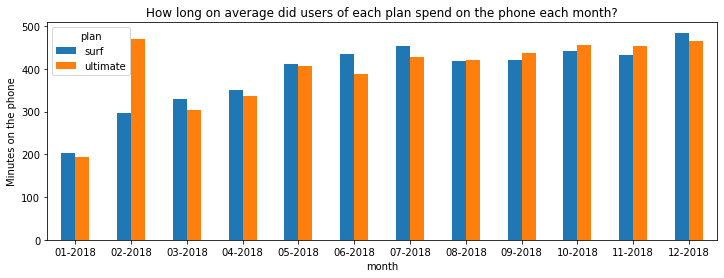

In [36]:
# Compare average duration of calls per each plan per each distinct month. Plot a bar plot to visualize it.
calls_pivot_mean = user_data_plans.pivot_table(index='month', columns='plan', aggfunc='mean', values='call_durations_sum')
calls_pivot_mean.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How long on average did users of each plan spend on the phone each month?')
plt.ylabel('Minutes on the phone')

In [37]:
# Store the different plan rows into different dataframes
user_data_surf = user_data_plans[user_data_plans.plan == 'surf']
user_data_ult = user_data_plans[user_data_plans.plan == 'ultimate']

# I want to see how much data is available for users of each plan
print(user_data_surf.shape)
print(user_data_ult.shape)

(1573, 8)
(720, 8)


Text(0.5, 1.0, 'How long did users spend on the phone per plan?')

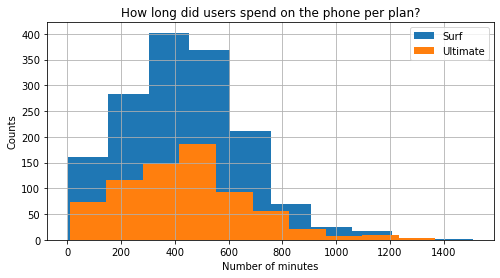

In [38]:
# Compare the number of minutes users of each plan require each month. Plot a histogram.

user_data_surf.call_durations_sum.hist(figsize=(8,4))
user_data_ult.call_durations_sum.hist()
plt.legend(['Surf', 'Ultimate'])
plt.ylabel('Counts')
plt.xlabel('Number of minutes')
plt.title('How long did users spend on the phone per plan?')

Text(0, 0.5, 'Minutes on the phone')

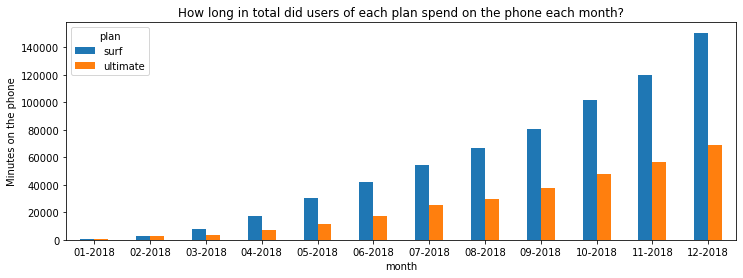

In [39]:
# I want to see how many minutes users spent on the phone each month in total per plan.
calls_pivot_sum = user_data_plans.pivot_table(index='month', columns='plan', aggfunc='sum', values='call_durations_sum')
calls_pivot_sum.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How long in total did users of each plan spend on the phone each month?')
plt.ylabel('Minutes on the phone')

# The mean amount of time that users spent on the phone is somewhat consistent later in the year, yet
# the total number of minutes rises throughout the entire year.

In [40]:
# Define function to return mean, variance, and standard deviation for a series
def get_stat_data(series):
    return series.mean(), series.var(), series.std()

# Define function to display data
def show_stats(name, tuple1, tuple2):
    display(f'Surf {name} Mean, Variance, Standard Deviation:', tuple1)
    display(f'Ultimate {name} Mean, Variance, Standard Deviation:', tuple2)

In [41]:
# Calculate the mean and the variance of the monthly call duration
surf_call_tuple = get_stat_data(user_data_surf.call_durations_sum)
ult_call_tuple = get_stat_data(user_data_ult.call_durations_sum)

show_stats('Call Length', surf_call_tuple, ult_call_tuple)

'Surf Call Length Mean, Variance, Standard Deviation:'

(436.80246113989637, 52481.56108272692, 229.08854419793)

'Ultimate Call Length Mean, Variance, Standard Deviation:'

(435.2865168539326, 56387.085162534124, 237.45964954605262)

In [42]:
# Realized after finishing my project that a pivot table would be much more elegant!
call_pivot = user_data_plans.pivot_table(index='plan', values='call_durations_sum', aggfunc=['mean', 'var', 'std', 'median'])
display(call_pivot)

,mean,var,std,median
,call_durations_sum,call_durations_sum,call_durations_sum,call_durations_sum
plan,,,,
surf,436.802461,52481.561083,229.088544,430.0
ultimate,435.286517,56387.085163,237.459650,425.5


Text(0, 0.5, 'Call durations')

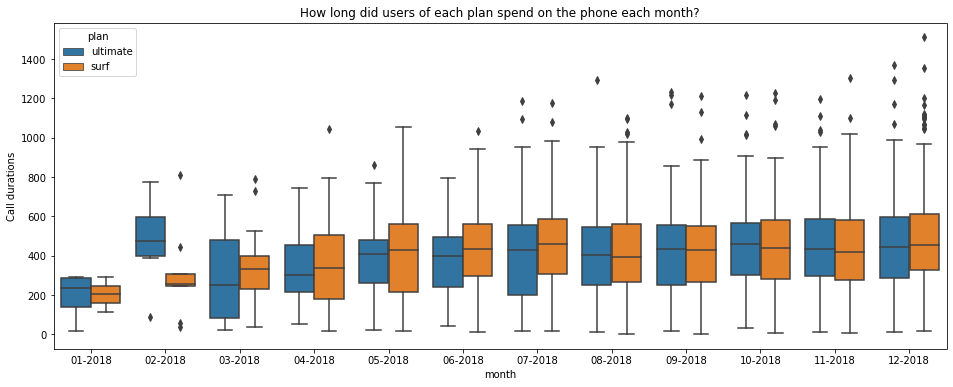

In [43]:
# Plot a boxplot to visualize the distribution of the monthly call duration

# Define an order of months for this and future boxplots
order = sorted(user_data_plans.month.unique())

plt.figure(figsize=(16,6))
sns.boxplot(data=user_data_plans, hue='plan', x='month', y='call_durations_sum', order=order)
plt.title('How long did users of each plan spend on the phone each month?')
plt.ylabel('Call durations')

There was high variation between plans in average call durations at the beginning of the year. The mean/median call durations are generally quite different from months 1-5. From months 6-12, the means, medians, overall distributions look very similar.

Throughout the year, the average amount of time that users spent on the phone each month increased a bit; meanwhile, the total amount of time spent on the phone across all customers per plan per month grew at a high rate. This suggests that Megaline's customer base grew at a proportionally high rate throughout the year.

### Messages

Text(0, 0.5, 'Number of messages')

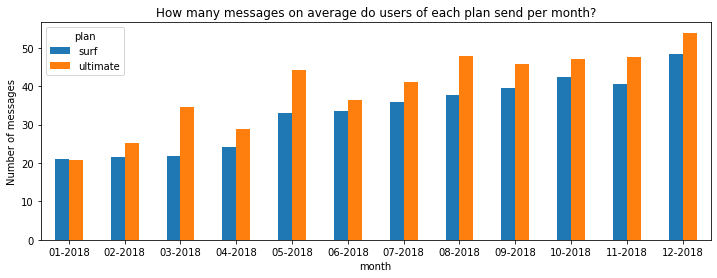

In [44]:
# Compare the mean number of messages users of each plan tend to send each month
messages_pivot_mean = user_data_plans.pivot_table(index='month', columns='plan', values='number_of_messages')
messages_pivot_mean.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How many messages on average do users of each plan send per month?')
plt.ylabel('Number of messages')

Text(0.5, 1.0, 'How many messages did customers send per plan?')

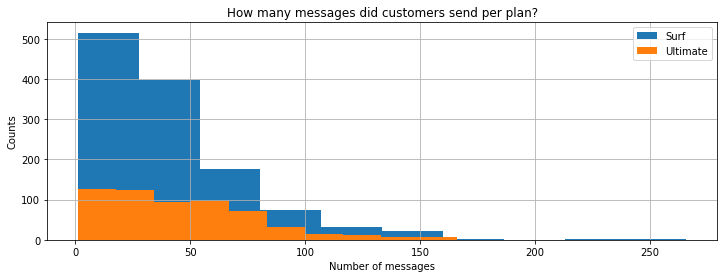

In [45]:
# Plot histogram for the number of messages sent per plan per month
user_data_surf.number_of_messages.hist(figsize=(12,4))
user_data_ult.number_of_messages.hist()

plt.legend(['Surf', 'Ultimate'])
plt.ylabel('Counts')
plt.xlabel('Number of messages')
plt.title('How many messages did customers send per plan?')

Text(0, 0.5, 'Number of messages')

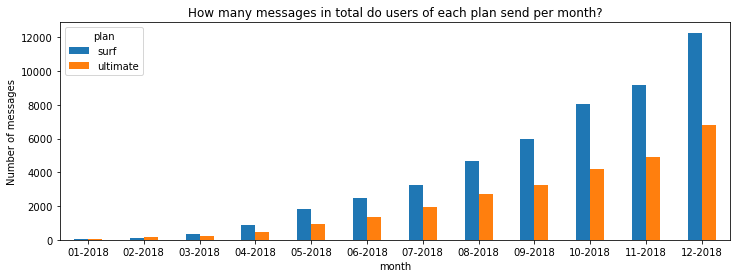

In [46]:
# Compare the total number of messages users of each plan tend to send each month
messages_pivot_sum = user_data_plans.pivot_table(index='month', columns='plan', aggfunc='sum', values='number_of_messages')
messages_pivot_sum.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How many messages in total do users of each plan send per month?')
plt.ylabel('Number of messages')

In [47]:
call_pivot = user_data_plans.pivot_table(index='plan', values='number_of_messages', aggfunc=['mean', 'var', 'std', 'median'])
display(call_pivot)

,mean,var,std,median
,number_of_messages,number_of_messages,number_of_messages,number_of_messages
plan,,,,
surf,40.109656,1091.344231,33.035500,32.0
ultimate,46.296233,1085.183108,32.942118,41.0


Text(0, 0.5, 'Number of messages')

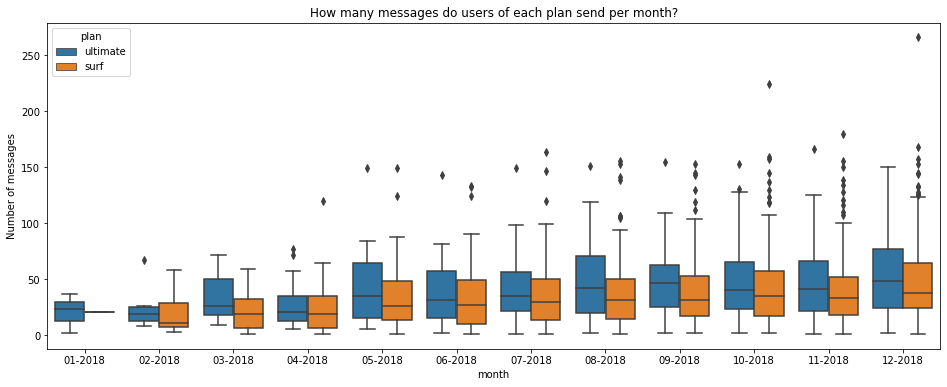

In [48]:
# Plot boxplot for messages sent per plan per month
plt.figure(figsize=(16,6))
sns.boxplot(data=user_data_plans, hue='plan', x='month', y='number_of_messages', order=order)
plt.title('How many messages do users of each plan send per month?')
plt.ylabel('Number of messages')

Ultimate plan users send more messages nearly every month of the year; on average, they send 6 more messages a month than users in the Surf plan. The distributions in months 5-12 remain consistent, whereas the distributions in months 1-4 vary quite a bit.

The number of messages sent in total increased throughout the year for both plans. 

### Internet

Text(0, 0.5, 'Number of megabytes used')

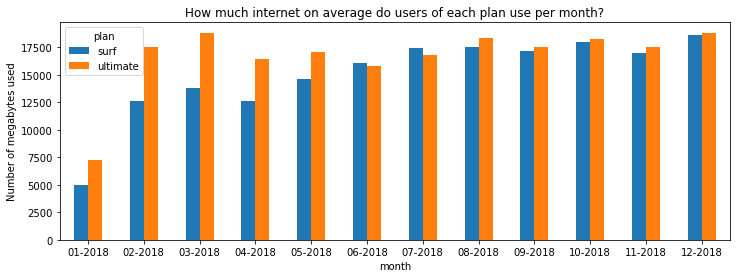

In [49]:
# Compare the mean amount of internet traffic consumed by users per plan
internet_pivot_mean = user_data_plans.pivot_table(index='month', columns='plan', values='mb_used_total')
internet_pivot_mean.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How much internet on average do users of each plan use per month?')
plt.ylabel('Number of megabytes used')

Text(0.5, 1.0, 'How many MBs did customers use per plan?')

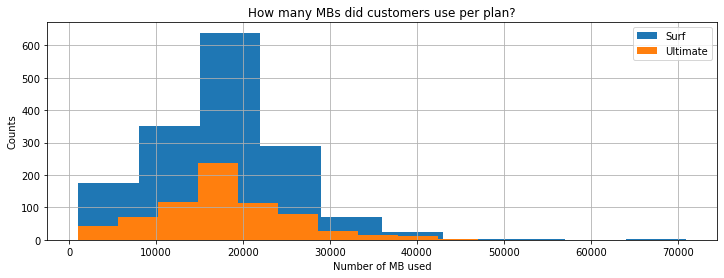

In [50]:
# Plot histogram on mb used per plan per month
user_data_surf.mb_used_total.hist(figsize=(12,4))
user_data_ult.mb_used_total.hist()

plt.legend(['Surf', 'Ultimate'])
plt.ylabel('Counts')
plt.xlabel('Number of MB used')
plt.title('How many MBs did customers use per plan?')

Text(0, 0.5, 'Number of megabytes used')

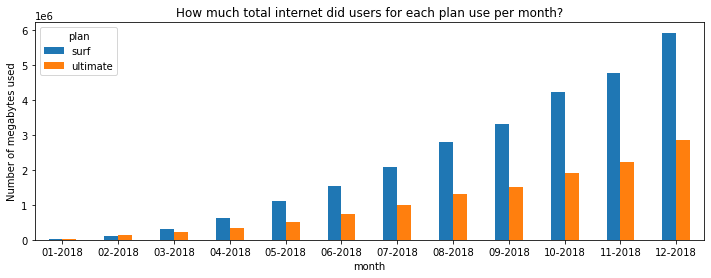

In [51]:
# Plot bar chart on how much internet customers used per plan per month
internet_pivot_sum = user_data_plans.pivot_table(index='month', columns='plan', aggfunc='sum', values='mb_used_total')
internet_pivot_sum.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How much total internet did users for each plan use per month?')
plt.ylabel('Number of megabytes used')

In [52]:
call_pivot = user_data_plans.pivot_table(index='plan', values='mb_used_total', aggfunc=['mean', 'var', 'std', 'median'])
display(call_pivot)

,mean,var,std,median
,mb_used_total,mb_used_total,mb_used_total,mb_used_total
plan,,,,
surf,17201.540436,6.205826e+07,7877.706743,17000.0
ultimate,17744.089013,6.151102e+07,7842.896150,17000.0


Text(0, 0.5, 'Number of megabytes used')

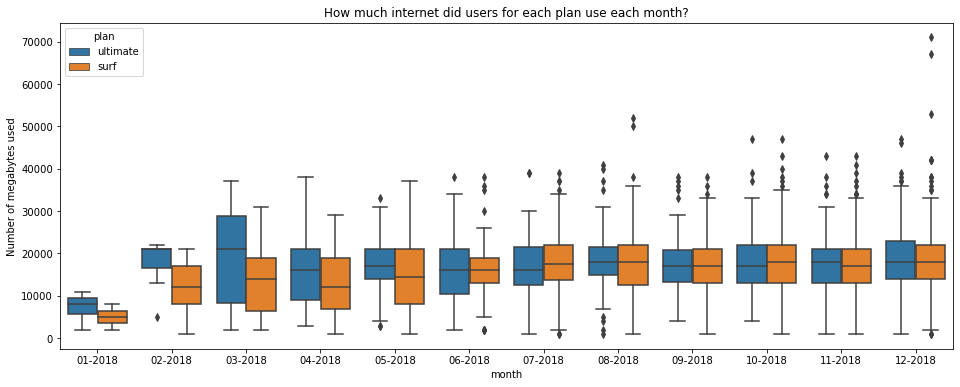

In [53]:
# PLot boxplot on internet used
plt.figure(figsize=(16,6))
sns.boxplot(data=user_data_plans, hue='plan', x='month', y='mb_used_total', order=order)
plt.title('How much internet did users for each plan use each month?')
plt.ylabel('Number of megabytes used')

The pattern of distributions throughout the year is similar to those of the previous data. Months 1-4 vary, then months 6-12 are consistent in terms of mean, median, and spread. In months 2 and 3, Ultimate users used much more internet on average than Surf users.

The number of megabytes used in total again increased throughout the year.

## Revenue

Text(0, 0.5, 'Revenue generated ($)')

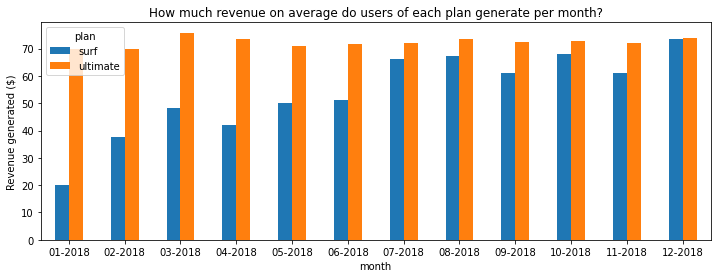

In [54]:
# Plot bar chart on revenue generated per plan per month
revenue_pivot_mean = user_data_plans.pivot_table(index='month', columns='plan', values='revenue')
revenue_pivot_mean.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How much revenue on average do users of each plan generate per month?')
plt.ylabel('Revenue generated ($)')

Text(0.5, 1.0, 'How much revenue did users generate per plan?')

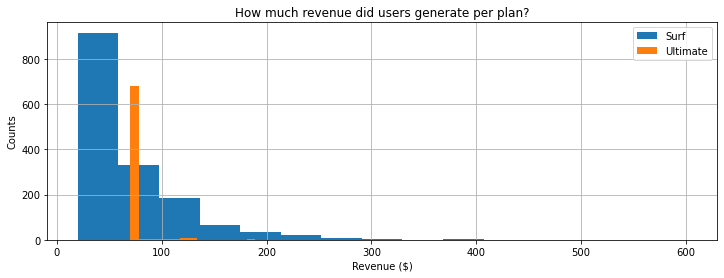

In [55]:
# Plot histogram on revenue generated per plan per month
user_data_surf.revenue.hist(figsize=(12,4), bins=15)
user_data_ult.revenue.hist(bins=15)

plt.legend(['Surf', 'Ultimate'])
plt.ylabel('Counts')
plt.xlabel('Revenue ($)')
plt.title('How much revenue did users generate per plan?')

Text(0, 0.5, 'Revenue generated ($)')

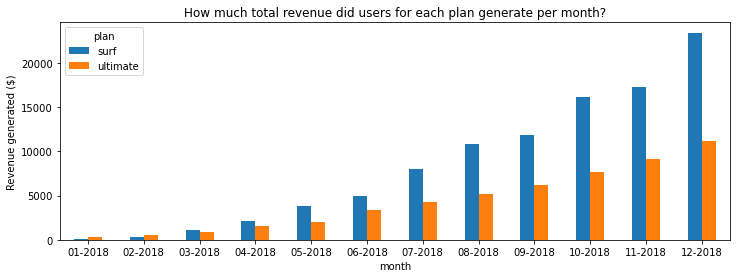

In [56]:
# Plot bar chat on revenue generated per plan per month 
revenue_pivot_sum = user_data_plans.pivot_table(index='month', columns='plan', aggfunc='sum', values='revenue')
revenue_pivot_sum.plot(kind='bar', figsize=(12,4), rot=0)
plt.title('How much total revenue did users for each plan generate per month?')
plt.ylabel('Revenue generated ($)')

In [57]:
call_pivot = user_data_plans.pivot_table(index='plan', values='revenue', aggfunc=['mean', 'var', 'std', 'median'])
display(call_pivot)

,mean,var,std,median
,revenue,revenue,revenue,revenue
plan,,,,
surf,63.611685,3295.597694,57.407297,43.81
ultimate,72.702778,160.606946,12.673080,70.00


Text(0, 0.5, 'Revenue generated ($)')

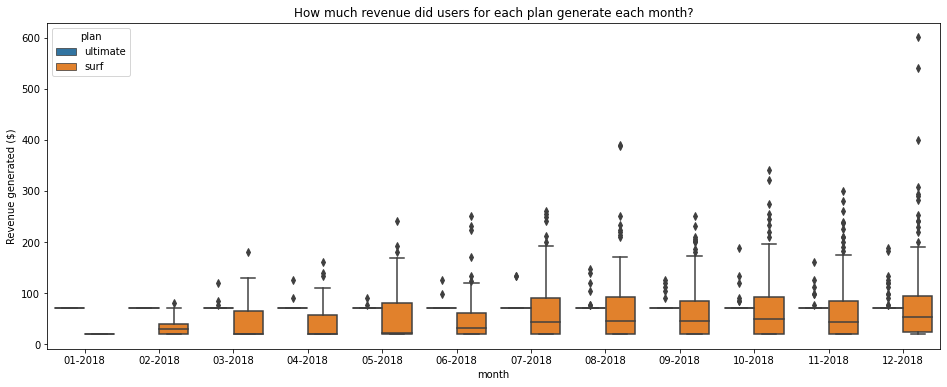

In [58]:
# Plot boxplot on revenue generated per plan per month
plt.figure(figsize=(16,6))
sns.boxplot(data=user_data_plans, hue='plan', x='month', y='revenue', order=order)
plt.title('How much revenue did users for each plan generate each month?')
plt.ylabel('Revenue generated ($)')

It appears that the typical Ultimate user generates more revenue than the typical Surf user. The Surf plan overall seems to bring in more revenue in total than the Ultimate plan, as the Surf plan has more users in the sample. However, we ultimately wish to examine the average revenue from users, not the total revenue.

The average Ultimate user generates $11 more revenue than the average Surf user, and the variance in the Ultimate user revenue data is significantly lower than in that of the Surf user revenue data. The median revenue from Ultimate users is higher than the median revenue from Surf users, though there are some very high outliers from Surf users.

[Text(0, 0, '01-2018'),
 Text(1, 0, '02-2018'),
 Text(2, 0, '03-2018'),
 Text(3, 0, '04-2018'),
 Text(4, 0, '05-2018'),
 Text(5, 0, '06-2018'),
 Text(6, 0, '07-2018'),
 Text(7, 0, '08-2018'),
 Text(8, 0, '09-2018'),
 Text(9, 0, '10-2018'),
 Text(10, 0, '11-2018'),
 Text(11, 0, '12-2018')]

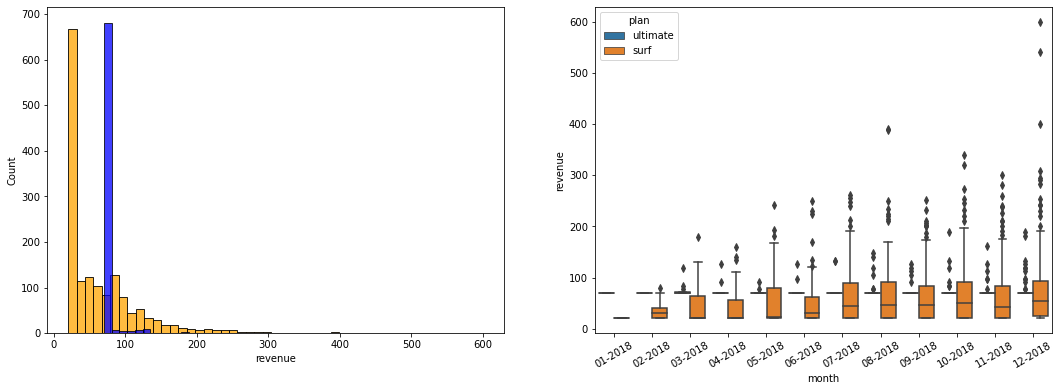

In [59]:
# Let's practice a cleaner way to view the distribution of data
fig, axes = plt.subplots(1, 2, figsize=(18,6))

ax1 = sns.histplot(user_data_surf.revenue, ax=axes[0], color='orange')
ax1 = sns.histplot(user_data_ult.revenue, ax=axes[0], color='blue')

ax2 = sns.boxplot(data=user_data_plans, hue='plan', x='month', y='revenue', ax=axes[1], order=order)
ax2.set_xticklabels(order, rotation=30)

## Test statistical hypotheses

- My null hypothesis is that the mean revenues for both Ultimate and Surf users are equal.
- My alternative hypothesis is that the mean revenues for both plans are not equal.

I will use a T-test, looking at two independent samples.
I will set my alpha at 0.05.

In [60]:
# I will want to use Levene's test to check whether the variances can be considered to be about equal or not.
# A p-value less than 0.05 leads to us rejecting the null hypothesis, which indicates that variance is not equal.
# A p-value greater than 0.05 leads us to fail to reject the null hypothesis, which indicates that variance is about equal.

def levene_test(sample1, sample2, center):
    results = st.levene(sample1, sample2, center=center)
    print(results)
    if results.pvalue < 0.05:
        print('We reject the null hypothesis. Variances may not be equal.')
    else:
        print('We cannot reject the null hypothesis. Variances may be about equal.')

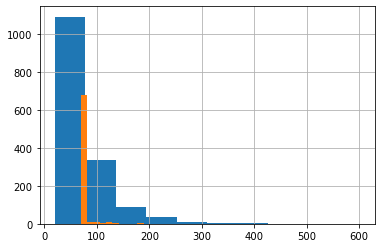

LeveneResult(statistic=432.4350750021274, pvalue=4.0055889782474175e-88)
We reject the null hypothesis. Variances may not be equal.


In [61]:
# Let's check if the variances can be considered to be about equal or not.

# Let's look for normality in the distributions.
user_data_surf.revenue.hist()
user_data_ult.revenue.hist()
plt.show()

# The default center='median' setting will work, because the distributions are skewed.
levene_test(user_data_surf.revenue, user_data_ult.revenue, 'median')

In [62]:
# Test the hypotheses

alpha = 0.05

results = st.ttest_ind(user_data_surf.revenue, user_data_ult.revenue, equal_var=False)

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print("We can't reject the null hypothesis.")

p-value: 2.81373182813939e-09
We reject the null hypothesis.


We reject the null hypothesis, as there is an extremely low probability that these results would exist in a universe where the two means are equal. The data from earlier in the project suggests that the revenue generated by the average Ultimate user in 2018 is greater than that generated by the average Surf user in 2018. Given that the p-value indicates that the difference between these means is significant, we can be fairly confident that the average Ultimate user indeed generated more revenue in 2018 and that this difference in means was not random.

##############################################################################################################################

- My null hypothesis is that the average revenue from users in the NY-NJ area is equal to the average revenue from users in other areas.
- My alternative hypothesis is that the average revenue from users in the NY-NJ area is not equal to the average revenue from users in other areas.

I will use a T-test that compares the significance of the difference between the means of two independent samples. I will determine the mean and variance for each sample first, and set my alpha at 0.05 again. 

In [63]:
# First let's prepare the data by merging user information onto our table with revenue
user_data_plans_cities = user_data_plans.merge(users, how='left', on=['user_id'])
user_data_plans_cities = user_data_plans_cities[['user_id', 'month', 'revenue', 'city']]

# Now let's store the relevant rows into separate dataframes
mask = 'New York-Newark-Jersey City, NY-NJ-PA MSA'
revenue_ny_nj = user_data_plans_cities.query('city == @mask')
revenue_not_ny_nj = user_data_plans_cities.query('city != @mask')

# Let's check for mean and variance between the revenue from these two tables
ny_nj_revenue_tuple = get_stat_data(revenue_ny_nj.revenue)
not_ny_nj_revenue_tuple = get_stat_data(revenue_not_ny_nj.revenue)

display('NY-NJ Revenue Mean, Variance, Std Dev:', ny_nj_revenue_tuple)
display('Not NY-NJ Revenue Mean, Variance, Std Dev:', not_ny_nj_revenue_tuple)

'NY-NJ Revenue Mean, Variance, Std Dev:'

(62.72506631299736, 2050.7343468705963, 45.28503446913336)

'Not NY-NJ Revenue Mean, Variance, Std Dev:'

(67.20241649269305, 2380.985050397751, 48.79533840847659)

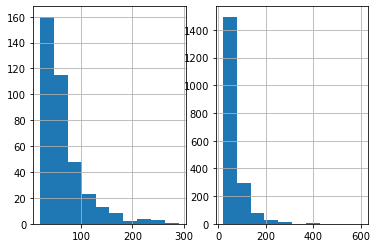

LeveneResult(statistic=2.9245049137322168, pvalue=0.08737938066626734)
We cannot reject the null hypothesis. Variances may be about equal.


In [64]:
# Let's check for normality. We will plot on seaparate graphs because the scales are much different
plt.subplot(1,2,1)
revenue_ny_nj.revenue.hist()
plt.subplot(1,2,2)
revenue_not_ny_nj.revenue.hist()
plt.show()

# They are skewed, so 'median' will work for the Levene test.
levene_test(revenue_ny_nj.revenue, revenue_not_ny_nj.revenue, 'median')

In [65]:
# Test the hypotheses

alpha = 0.05

results = st.ttest_ind(revenue_ny_nj.revenue, revenue_not_ny_nj.revenue) # Keep default setting equal_var=True

print('p-value:', results.pvalue)

if results.pvalue < alpha:
    print('We reject the null hypothesis.')
else:
    print('We cannot reject the null hypothesis.')

p-value: 0.0996049232160297
We cannot reject the null hypothesis.


With an alpha setting of 0.05, the results of this T-test do not allow us to reject the null hypothesis. It is very possible that these results exist in a universe where the mean revenue of those who live around NY-NJ is equal to the mean revenue of those who live elsewhere, and that the difference in these means was likely random.

## General conclusion

First I explored each dataset to make sure that datatypes and values made sense. I looked for duplicate rows and missing information. I changed a number of date strings into datetime objects, and extracted the month value into new rows. I added a bool column to the users DF indicating whether or not they churned in that year, and the length of time that they were a customer, but I did not end up using this information. I removed rows from the calls and internet DF's where call length and MB used were 0.00, so as to protect data regarding mean call lengths and MB used.

After that, I wanted to create a new dataframe that indexed by user and by month, and included information regarding their total call durations, messages sent, and MB used, and ultimately add revenue generated to the table. To do this, I first had to process call durations and MB used according to the plan parameters; individual call times were rounded up to the nearest minute, and monthly MB used were rounded up to the nearest GB. I created a dataframe using the processed monthly usage information, and merged user information onto it. Finally, I had the data necessary to calculate revenue. I wrote and applied a function that would move through each row and calculate the revenue generated per user per month based on the plan information, adding this revenue into a new column. I trimmed the table down to only helpful columns, and was able to use it as my primary source of data for the remainder of the project.

Although my main goal was to determine if there was significant statistical difference between the mean revenues generated from users of the two different plans, I wanted to look at patterns in user behavior. Users of both plans used similar amounts of call time and internet, whereas Ultimate users sent 7 more messages than Surf users, on average. The revenue generated from Ultimate users was consistently higher than that generated by Surf users. For all of the data, the first few months showed high variation before becoming more stable at around month 5, and continuing through the end of the year. Volume of each metric increased throughout the year, suggesting a steady increase in Megaline phone plan users throughout the year. 

Once I had explored the data, I moved on to statistical testing. 

First I wanted to test the null hypothesis that the revenue generated from users of each plan was equal in 2018. I used a T-test designed for determining the presence of a statistically significant difference in means between two independent samples. I used Levene's test first to determine whether the variances of the two samples were about equal or not. The data from earlier in the project suggests that the revenue generated by the average Ultimate user in 2018 is greater than that generated by the average Surf user in 2018. Given that the p-value indicates that the difference between these means is significant, we can be fairly confident that the average Ultimate user indeed generated more revenue in 2018 and that this difference in means was not random.

I also tested the null hypothesis that the average revenue from users in the NY-NJ area was equal to the average revenue from users in other areas in 2018. I again used a T-test and a Levene's test. With an alpha setting of 0.05, the results of this T-test did not allow us to reject the null hypothesis. It is very possible that these results exist in a universe where the mean revenue of those who live around NY-NJ is equal to the mean revenue of those who live elsewhere, and that the difference in these means was likely random.

On an individual level, I got more practice exploring, describing, and summarizing data, and thinking/writing statistically.